**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.

The remaining of this notebook goes through all the important components of a 3D magnetic experiment. From mesh creation, topography, data and inverse problem. 

Enjoy.


In [1]:
%matplotlib notebook
%pylab
from SimPEG import *
import simpegPF as PF
from simpegPF import BaseMag as MAG


Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib
Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


C:\Users\dominiquef.MIRAGEOSCIENCE\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000.,90.,0.)


# Create a mesh
dx    = 5.

hxind = [(dx,5,-1.3), (dx, 20), (dx,5,1.3)]
hyind = [(dx,5,-1.3), (dx, 20), (dx,5,1.3)]
hzind = [(dx,5,-1.3),(5, 10)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple Gaussian topo and set the active cells
[xx,yy] = np.meshgrid(mesh.vectorNx,mesh.vectorNy)
zz = -np.exp( ( xx**2 + yy**2 )/ 75**2 ) + mesh.vectorNz[-1]

topo = np.c_[mkvc(xx),mkvc(yy),mkvc(zz)] # We would usually load a topofile

actv = PF.Magnetics.getActiveTopo(mesh,topo,'N') # Go from topo to actv cells

#nC   = mesh.nC 
#actv = np.asarray(range(mesh.nC))

# Create active map to go from reduce space to full
actvMap = Maps.ActiveCells(mesh, actv, -100)
nC = len(actv)

# Create and array of observation points
xr = np.linspace(-20., 20., 20)
yr = np.linspace(-20., 20., 20)
X, Y = np.meshgrid(xr, yr)

# Let just put the observation above the topo
Z = -np.exp( ( X**2 + Y**2 )/ 75**2 ) + mesh.vectorNz[-1] + 5. 

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = MAG.RxObs(rxLoc)
srcField = MAG.SrcField([rxLoc],H0)
survey = MAG.LinearSurvey(srcField) 


C:\Users\dominiquef.MIRAGEOSCIENCE\Documents\GIT\SimPEG\simpeg\SimPEG\Maps.py:533: FutureWarning: `ActiveCells` is deprecated and will be removed in future versions. Use `InjectActiveCells` instead
  FutureWarning)


Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would look like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [3]:
# We can now create a susceptibility model and generate data
# Lets start with a simple block in half-space
model = np.zeros((mesh.nCx,mesh.nCy,mesh.nCz))
model[(midx-2):(midx+2),(midy-2):(midy+2),-6:-2] = 0.01
model = mkvc(model)
model = model[actv]

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = len(actv))

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, mapping = idenMap, actInd = actv)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
d = prob.fields(model)

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



<IPython.core.display.Javascript object>


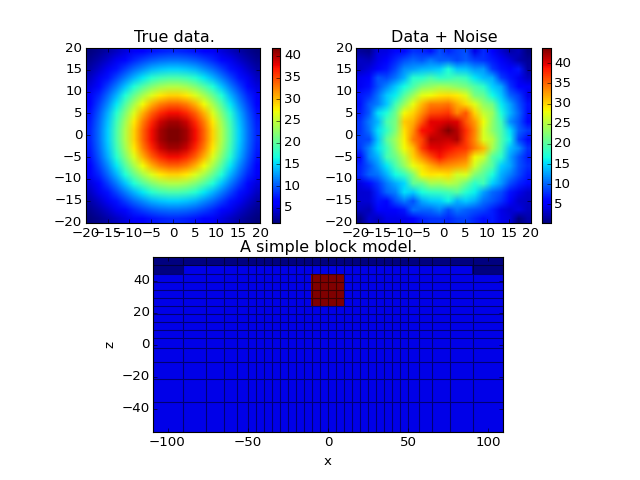

<matplotlib.colorbar.Colorbar instance at 0x0000000016394448>

In [4]:


# Plot the model
figure()
ax = subplot(212)
mesh.plotSlice(actvMap * model, ax = ax, normal = 'Y', ind=midy, grid=True, clim = (-1e-3, model.max()))
title('A simple block model.')
xlabel('x');ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

# We can now generate data
data = d + randn(len(d)) # We add some random Gaussian noise (1nT)
wd = np.ones(len(data))*1. # Assign flat uncertainties


subplot(221)
imshow(d.reshape(X.shape), extent=[xr.min(), xr.max(), yr.min(), yr.max()])
title('True data.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

subplot(222)
imshow(data.reshape(X.shape), extent=[xr.min(), xr.max(), yr.min(), yr.max()])
title('Data + Noise')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()


<IPython.core.display.Javascript object>


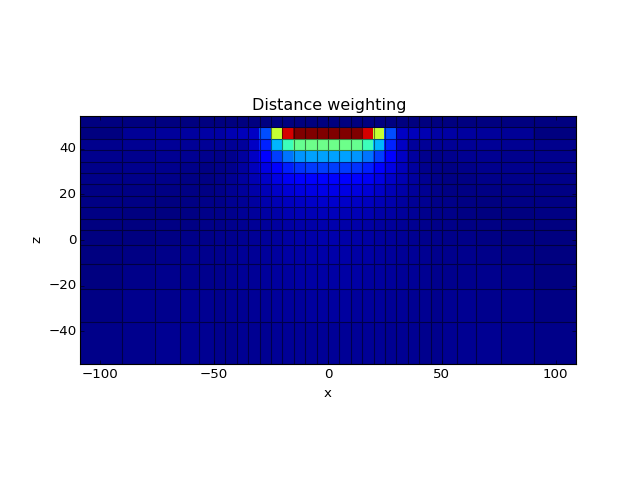

In [5]:
# Create distance weights from our linera forward operator
wr = np.sum(prob.G**2.,axis=0)**0.5
wr = ( wr/np.max(wr) )


wr_FULL = actvMap * wr
plt.figure()
ax = subplot()
mesh.plotSlice(wr_FULL, ax = ax, normal = 'Y', ind=midx, grid=True, clim = (0, wr.max()))
title('Distance weighting')
xlabel('x');ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [10]:
#survey.makeSyntheticData(data, std=0.01)
survey.dobs=data
survey.std = np.ones(len(data))
survey.mtrue = model

# Create a regularization
reg = Regularization.Simple(mesh, indActive = actv, mapping = idenMap)
reg.wght = wr

# Directive to cool the trade-off parameter beta
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
beta_in = 1e+4

# Create a jacobi pre-conditioner
diagA = np.sum(prob.G**2.,axis=0) + beta_in*(reg.W.T*reg.W).diagonal()
PC     = Utils.sdiag(diagA**-1.)

# Define the misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./survey.std


# Solver for the optimization problem
opt = Optimization.ProjectedGNCG(maxIter=10, lower=0.,upper=1., maxIterCG= 30, tolCG = 1e-3)
opt.approxHinv = PC

# Put everything together
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta = beta_in)
target = Directives.TargetMisfit()

inv = Inversion.BaseInversion(invProb, directiveList=[beta,target])
m0 = np.ones(mesh.nC)*1e-4
m0 = m0[actv]

In [11]:
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.00e+04  6.73e+04  0.00e+00  6.73e+04    8.30e+01      0              
   1  5.00e+03  1.33e+03  3.52e-02  1.50e+03    6.45e+01      0              
   2  2.50e+03  3.14e+02  5.17e-02  4.44e+02    7.06e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 6.7288e+03
1 : |xc-x_last| = 1.6646e-02 <= tolX*(1+|x0|) = 1.0111e-01
0 : |proj(x-g)-x|    = 7.0593e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.0593e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10   

Inversion has converged. We can plot sections through the model.

<IPython.core.display.Javascript object>


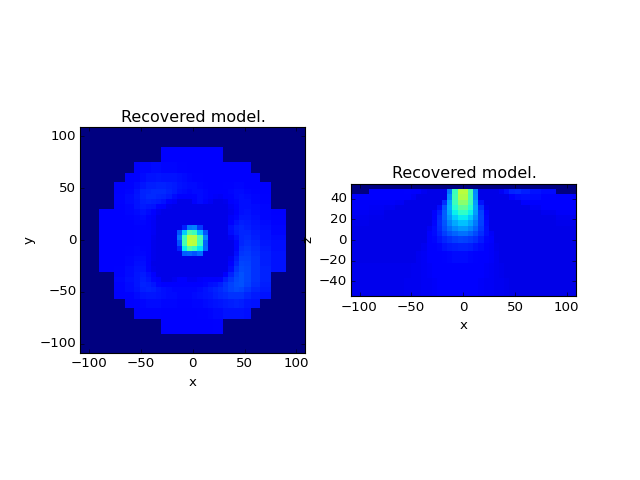

In [12]:
# Here is the recovered susceptibility model
plt.figure()
ax = subplot(121)
mesh.plotSlice(actvMap * mrec, ax = ax, normal = 'Z', ind=-2, clim = (-1e-3, model.max()))
title('Recovered model.')
xlabel('x');ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')


# Horizontalsection
ax = subplot(122)
mesh.plotSlice(actvMap * mrec, ax = ax, normal = 'Y', ind=midx, clim = (-1e-3, model.max()))
title('Recovered model.')
xlabel('x');ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')



Great, we have a 3D model of susceptibility, but the job is not done yet.
A VERY important step of the inversion workflow is to look at how well the model can predict the observed data.
The figure below compares the observed, predicted and normalized residual.


<IPython.core.display.Javascript object>


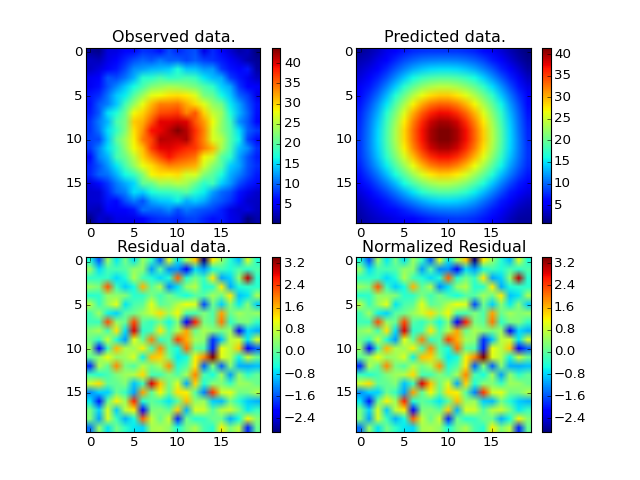

<matplotlib.colorbar.Colorbar instance at 0x000000001BC6F288>

In [9]:
# Plot predicted data and residual
plt.figure()
pred = prob.fields(mrec)  #: this is matrix multiplication!!

subplot(221)
imshow(data.reshape(X.shape))
title('Observed data.')
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

subplot(222)
imshow(pred.reshape(X.shape))
title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

subplot(223)
imshow(data.reshape(X.shape) - pred.reshape(X.shape))
title('Residual data.')
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

subplot(224)
imshow( (data.reshape(X.shape) - pred.reshape(X.shape)) / wd.reshape(X.shape) )
title('Normalized Residual')
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

Good job! 
Hopefully we covered all the important points regarding the inversion of magnetic field data using the integral formulation.

Make sure you visit the notebook for the compact norms regularization.

Cheers!